In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import interp1d
import scipy.optimize as op
import emcee
import corner

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 15

In [2]:
def lnprior(theta):
    tpeak, dur, ampl = theta
    if -5. < tpeak < 100 and 0.0 < dur and 0.0 < ampl:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikelihood(theta, x, y, yerr)

def loglikelihood(theta, time, y, yerr):
    tpeak, dur, ampl = theta
    m = aflare(time, tpeak, dur, ampl)
    l1 = (y - m)**2 / yerr**2 + np.log(2 * np.pi * yerr**2)
    lsum = -.5 * np.nansum(l1) 
    return lsum

from scipy.stats import binned_statistic

def aflare(t, tpeak, dur, ampl, upsample=True, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    dur : float
        The duration of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    fwhm = dur/2. # crude approximation for a triangle shape would be dur/2.
    
    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                     bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude
      

    return flare



In [4]:

df = pd.read_csv("../flare_tables/20200227_vetted_flares_lacking_some.csv")
df = df[df.real == 1] 
df = df[df.complex == 0]
df = df[df.ampl_rec > .01]
#df = df[(df.cstop-df.cstart) < 60]
df = df[(df.cstop-df.cstart) > 4]


series = {}

for cond, S, color in [#((df.st == 6), "M6", "red"),
                       #((df.st == 7), "M7", "blue"),
                       #((df.st == 8), "M8", "orange"),
                       #((df.st == 9), "M9", "green"),
                     #((df.st > 6), ">M6", "grey"),
                       ((df.st>5),"all", "k")
                      ]:

    d = df[cond]
    n = d.shape[0]
    
    a = np.ones((n, 100));
    ns, ni = 100000, 0
    plt.figure(figsize=(10,8))
    
    for i in range(n):
        l = d[["TIC","sector","cstart"]].iloc[i]
        s =f"{str(l.TIC).zfill(16)}_{l.sector}_{l.cstart}_long.csv"
        f = pd.read_csv(f"../flare_snippets/{s}")
        f = f.iloc[90:-160,:]
        
        # Interpolation
        try:
            interp = interp1d(f.c, f.f, kind='linear')
            time = np.linspace(f.c.values[0], f.c.values[-1],f.shape[0]*20 ) # scale up to Davenport upsampling
            flux = (interp(time) -1.)
        except:
            print(s)
            continue
        
        # Scale to FWHM
        maxflux = np.max(flux)
        argmaxflux = np.argmax(flux)
        t12rise = np.argmin(np.abs(flux[:argmaxflux] * 2. - maxflux))  
        t12decay = np.argmin(np.abs(flux[argmaxflux:] * 2. - maxflux))
        t12 = time[argmaxflux + t12decay] - time[t12rise]
        
        timet12 = (time - time[argmaxflux]) / t12
        fluxt12 = flux / maxflux
        
        # Find good time series to reindex to
        series[i] = pd.Series(fluxt12, index=timet12)
       
        if timet12.shape[0] < ns:
            if ((timet12[0]<=-5.) & (timet12[-1]>=20.)):
                ns = timet12.shape[0]
                ni = i
        # plot individual flares
        #plt.plot(timet12, fluxt12, c="orange", alpha=.2)
    
    # stack an average
    df = pd.DataFrame(series)
    df = df[(df.index > -5.) & (df.index<20.)]
    df2 = df.interpolate("index").reindex(index=series[ni].index.values,
                                          columns=df.columns.values)
    meanval = df2[(df2.index>-5.)].median(axis=1)
    stdval = np.sqrt(df2[(df2.index>-5.)].var(axis=1))
    time, flux, flux_err = meanval.index, meanval.values, stdval.values
    condit = np.where(np.invert(np.isnan(time)) &
                      np.invert(np.isnan(flux)) &
                      np.invert(np.isnan(flux_err)))
    time, flux, flux_err = time[condit], flux[condit], flux_err[condit]
    
#     # plot average + std
#     plt.plot(time, flux, c="r", linewidth=2)
#     plt.fill_between(x=time,
#                      y1=flux - flux_err,
#                      y2=flux + flux_err, 
#                      facecolor="r",alpha=.6,
#                      linewidth=1.)
    
#     # maximize likelihood to get init values for MCMC
#     nll = lambda *args: -loglikelihood(*args)
#     result = op.minimize(nll, [0.01,1.2,1.2], args=(time, flux, flux_err),options={ 'disp': True})
#     tpeak_ml, dur_ml, ampl_ml = result["x"]
    
    # run MCMC
#     ndim, nwalkers = 3, 100
#     pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(time, flux, flux_err))
#     sampler.run_mcmc(pos, 500)
    
#     # Plot MCMC result
#     samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
#     for tpeak, dur, ampl in samples[np.random.randint(len(samples), size=50)]:
#         plt.plot(time, aflare(time, tpeak, dur, ampl), color="k", alpha=0.1)
    
#     plt.xlim(-5,20)
#     plt.xlabel("time [FWHM]")
#     plt.ylabel("normalized flux");
    
#     # Finish figure
#     plt.savefig(f"../plots/{tstamp}_{S}_davenport_fit_median_norel_long.png", dpi=300)
#     plt.close()
    
#     # Plot cornerplot
#     fig = corner.corner(samples, labels=["$tpeak$", "$dur$", "$ampl$"],)
#     plt.savefig(f"../plots/{tstamp}_{S}_davenport_fit_mcmc_corner_median_norel_long.png", dpi=300)
#     plt.close()

0000000272349442_10_254934_long.csv
0000000167894019_12_306151_long.csv


<Figure size 720x576 with 0 Axes>

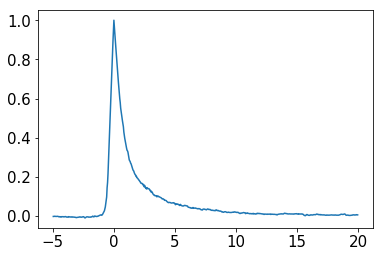

In [5]:
plt.plot(time, flux)

In [78]:
cond = (time<=0.) & (time>=-1.)
t_rise = time[cond]
f_rise = flux[cond]
ferr_rise = flux_err[cond]


In [84]:
def model_rise(a, b, c, d, t):

    return 1. + a * t + b * t**2 + c * t**3 + d * t**4


def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikelihood(theta, x, y, yerr)

def loglikelihood(theta, time, y, yerr):
    a, b, c, d = theta
    m = model_rise(a, b, c, d, time)
    l1 = (y - m)**2 / yerr**2 + np.log(2 * np.pi * yerr**2)
    lsum = -.5 * np.nansum(l1) 
    return lsum



def logit(function):
    '''Make a probability distribution
    a log probability distribution.'''
    def wrapper(*args, **kwargs):
        result = function(*args, **kwargs)
        np.seterr(divide='ignore') # ignore division by zero because you want to have the -np.inf results
        result = np.log(result)
        return result
    return wrapper


    
def lnprior(theta):
    """Uniform prior for start time,
    amplitude, and duration.
    - accounts for uncertainties in inclination (prior distribution=Gauss?)
    - latitude between 0 and 90 deg
    - longitude always positive (can go multiple periods into light curve)
    - FWHM always positive.
    - Amplitude always positive.
    Parameters:
    ------------
    theta : tuple
        start time, duration, amplitude
    x : array
        time array to constrain start time
    """
    a, b, c, d =  theta
    prior = (gaussian_prior(a, 1.941, 0.008) +
             gaussian_prior(b, -0.175, 0.032) +
             gaussian_prior(c, -2.246, 0.039) +
             gaussian_prior(d, -1.125, 0.016) 
            )
    return calculate_posterior_value_that_can_be_passed_to_mcmc(prior)

def calculate_posterior_value_that_can_be_passed_to_mcmc(lp):
    '''Do some checks to make sure MCMC will work.'''
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp):
        return -np.inf
    else:
        return lp

<ErrorbarContainer object of 3 artists>

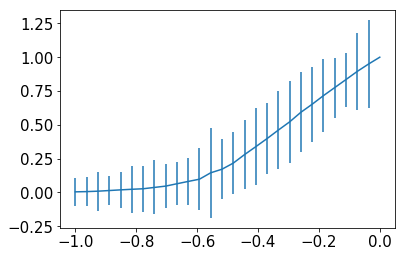

In [85]:
plt.errorbar(t_rise,f_rise,yerr=ferr_rise)

In [94]:
# run MCMC
ndim, nwalkers = 4, 100
truth = [1.941, -.175,  -2.246, -1.125]

In [96]:
pos = [[1.8, -.2,  -2.2, -1.1] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(t_rise, f_rise, ferr_rise))

sampler.run_mcmc(pos, 500, progress=True)

100%|██████████| 500/500 [03:32<00:00,  2.34it/s]


State([[ 1.93898859 -0.14915821 -2.21422656 -1.10220514]
 [ 1.94397996 -0.16706335 -2.24251739 -1.12394448]
 [ 1.94972762 -0.19773585 -2.26335747 -1.11633113]
 [ 1.9399571  -0.21378552 -2.23774942 -1.11174997]
 [ 1.92152742 -0.17390119 -2.25580574 -1.14528914]
 [ 1.94141235 -0.13753307 -2.27165448 -1.11608555]
 [ 1.94496207 -0.1517409  -2.25505001 -1.12700682]
 [ 1.95589223 -0.15262232 -2.2419789  -1.11807799]
 [ 1.95073617 -0.18352896 -2.2943964  -1.10509529]
 [ 1.94843537 -0.1504554  -2.2420889  -1.10760958]
 [ 1.93711548 -0.23684659 -2.23124326 -1.16403084]
 [ 1.93984407 -0.2112637  -2.29417798 -1.10860303]
 [ 1.94680799 -0.14087853 -2.22370546 -1.12241694]
 [ 1.94011707 -0.16638152 -2.28919257 -1.16038146]
 [ 1.94338697 -0.12810719 -2.18771645 -1.14404394]
 [ 1.93805474 -0.17642597 -2.26300241 -1.11345893]
 [ 1.93860194 -0.2228085  -2.23839619 -1.12951626]
 [ 1.94771385 -0.20170329 -2.24583584 -1.13205219]
 [ 1.93407862 -0.17178906 -2.24488116 -1.12653186]
 [ 1.93307017 -0.1711009 

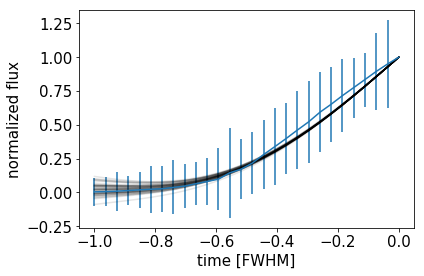

In [97]:
# Plot MCMC result
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
for a,b,c,d in samples[np.random.randint(len(samples), size=50)]:
    plt.plot(t_rise, model_rise(a,b,c,d,t_rise), color="k", alpha=0.1)
plt.errorbar(t_rise,f_rise,yerr=ferr_rise)
#plt.xlim(-2,0)
plt.xlabel("time [FWHM]")
plt.ylabel("normalized flux");

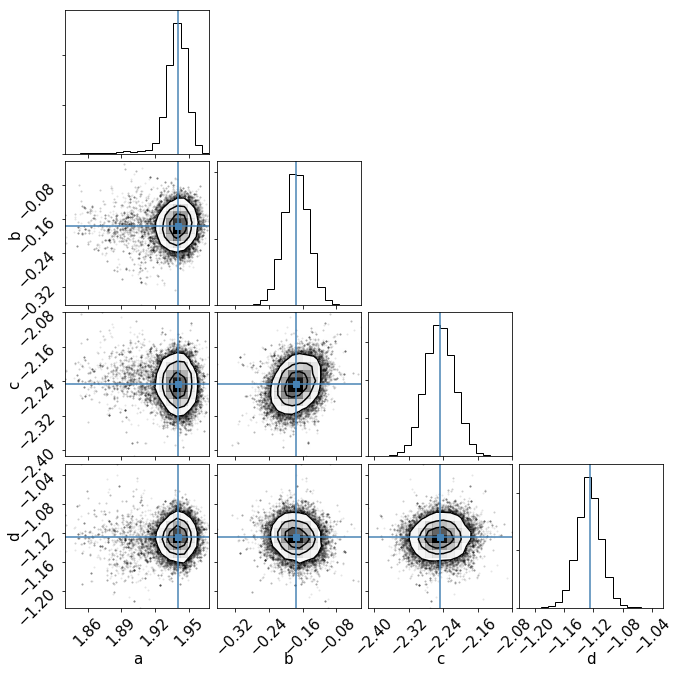

In [98]:
# Plot cornerplot
fig = corner.corner(samples, labels=["a","b","c","d"], truths=truth)
# plt.savefig(f"../plots/{tstamp}_{S}_davenport_fit_mcmc_corner_median_norel_long.png", dpi=300)
# plt.close()

In [82]:
gaussian_prior(1.0641500468176377, 1.941, 0.008)

-inf